In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import time
import seaborn as sns

## Load Divvy Data

In [2]:
# # used for the initial load
# ride_df = pd.read_csv('~/Downloads/Divvy_Trips.csv')

In [3]:
# load subsequent pickles
ride_df = pd.read_pickle('ride_df_pickle')

In [4]:
# # cleaning, used the first time before pickling

# # lowercase the columns
# ride_df.columns = [x.lower().replace(' ','_') for x in ride_df.columns]

# # print the shape of data
# print(f'data before cleaning: {ride_df.shape}')

# # drop unneccesary columns
# # ride_df.drop(['from_location','to_location'],axis=1, inplace=True)

# # convert 'start' to datetime
# ride_df['start_time'] = pd.to_datetime(ride_df['start_time'])

# # add a date only column
# ride_df['date'] = ride_df['start_time'].dt.date

# # print shape after cleaning
# print(f'data after cleaning: {ride_df.shape}')

In [5]:
# # to create a backup pickle to make loading faster
# ride_df.to_pickle('ride_df_pickle')

### grouped by dataframes

In [6]:
# date, with subset of membership type
day_sub_df = ride_df.groupby(['date','user_type']).agg({'trip_id': 'count'}).reset_index()

# date
day_rides_df = ride_df.groupby(['date']).agg({'trip_id': 'count'}).reset_index()

In [7]:
# station rides
station_rides = ride_df.groupby(['from_station_name']).agg({'trip_id':'count'}).reset_index()

In [8]:
station_rides.sample(2)

,from_station_name,trip_id
143,Clark St & Newport St,7820
495,Prairie Ave & 43rd St,1401


In [15]:
station = list(station_rides.sort_values('trip_id')['from_station_name'].tail(100))

In [16]:
len(station)

100

In [19]:
ride_df_100_stations = ride_df[ride_df['from_station_id'].isin(station)].copy()

In [23]:
ride_grouped_stations = ride_df.groupby(['from_station_name','date']).agg({'trip_id':'count',
                                                               'from_latitude':'max',
                                                               'from_longitude':'max'}).reset_index()

In [24]:
ride_grouped_stations = ride_grouped_stations.rename(columns={'trip_id': 'total_rides'})

In [122]:
ride_grouped_stations.sort_values('date')

,from_station_name,date,total_rides,from_latitude,from_longitude,temp,trip_id,temp_bins,day
0,2112 W Peterson Ave,2016-09-01,1,41.991178,-87.683593,68.36825,14435,60+,Weekday
341,Oakley Ave & Irving Park Rd,2016-09-01,5,41.954341,-87.686080,68.36825,14435,60+,Weekday
340,Oak Park Ave & South Blvd,2016-09-01,4,41.886923,-87.793899,68.36825,14435,60+,Weekday
339,Oak Park Ave & Harrison St,2016-09-01,2,41.872987,-87.793945,68.36825,14435,60+,Weekday
338,Normal Ave & Archer Ave,2016-09-01,3,41.849527,-87.640591,68.36825,14435,60+,Weekday
...,...,...,...,...,...,...,...,...,...
372642,Ellis Ave & 60th St,2019-09-30,49,41.785097,-87.601073,75.21425,18256,70+,Weekday
372641,Ellis Ave & 58th St,2019-09-30,32,41.788746,-87.601334,75.21425,18256,70+,Weekday
372640,Ellis Ave & 55th St,2019-09-30,75,41.794301,-87.601450,75.21425,18256,70+,Weekday
372638,Elizabeth (May) St & Fulton St,2019-09-30,24,41.886616,-87.658040,75.21425,18256,70+,Weekday


## Load the weather Data

In [26]:
# open weather map
weather_df = pd.read_csv('chicago_weather.csv')

# remove UTC from datetime
weather_df['dt_iso'] = weather_df['dt_iso'].map(lambda x: x[:-4])

# convert to datetime
weather_df['dt_iso'] = pd.to_datetime(weather_df.dt_iso, utc=True)

# convert to central time
weather_df['dt_iso'] = pd.DatetimeIndex(weather_df['dt_iso']).tz_convert('US/Central')

# add a date column
weather_df['date'] = weather_df.dt_iso.dt.date

# convert to farenheight
weather_df['temp'] = weather_df['temp'] * (9/5) +32

# set columns to drop
col_to_drop = ['dt','lat','lon','pressure','sea_level','grnd_level','rain_12h','rain_today','snow_12h','snow_today']

# drop most columns ^
weather_df.drop(col_to_drop,axis=1,inplace=True)

### Create the 'bad weather' df

In [27]:
# count of weather types
weather_df.groupby(['weather_main']).agg({'date':'count'}).reset_index().sort_values('date',ascending=False)

,weather_main,date
1,Clouds,55508
0,Clear,9053
7,Rain,8710
6,Mist,5518
9,Snow,3034
2,Drizzle,783
5,Haze,595
10,Thunderstorm,437
4,Fog,220
8,Smoke,24


In [28]:
rain_df = weather_df[(weather_df['weather_main']=='Rain') | (weather_df['weather_main']=='Thunderstorm') | (weather_df['weather_main']=='Snow')]
rain_df = rain_df.groupby('date').agg({'dt_iso':'count'})
rain_df['bad_weather'] = 1

rain_final = rain_df.drop('dt_iso', axis=1).reset_index()
rain_final.sample(2)

,date,bad_weather
772,2015-01-25,1
804,2015-03-25,1


### Create the 'temperature' dfs

In [29]:
temp_df = weather_df.groupby('date').agg({'temp':'mean'}).reset_index()
temp_df.sample()

,date,temp
2104,2016-09-03,68.12825


# Open and clean weather data

#### Weather Rides

In [30]:
# merge weather with rides
rides_weather = pd.merge(day_rides_df,rain_final,on='date',how='left')

# fill na values
rides_weather['bad_weather'] = rides_weather['bad_weather'].fillna(0)

# rename the trip_id column
rides_weather.rename(columns={'trip_id': 'num_rides'}, inplace=True)

In [31]:
rides_weather.bad_weather.value_counts()

1.0    595
0.0    530
Name: bad_weather, dtype: int64

In [32]:
# # save to pickle
# rides_weather.to_pickle('~/Desktop/rides_weather_nodrizzle.pickle')

#### Membership Segmentation

In [33]:
# merge weather with membership rides
mem_rides_weather = pd.merge(day_sub_df,rain_final,on='date',how='left')

# fill na values
mem_rides_weather['bad_weather'] = mem_rides_weather['bad_weather'].fillna(0)

# rename the trip_id column
mem_rides_weather.rename(columns={'trip_id': 'num_rides'}, inplace=True)

In [34]:
mem_rides_weather.bad_weather.value_counts()

1.0    1197
0.0    1077
Name: bad_weather, dtype: int64

In [35]:
# write to pickle
mem_rides_weather.to_pickle('mem_rides_weather.pickle')

## Temperature

In [36]:
# merge weather with membership rides
rides_temp_df = pd.merge(day_rides_df,temp_df,on='date',how='left')
print(rides_temp_df.sample())

           date  trip_id      temp
122  2017-01-01     1727  29.74175


In [37]:
def temp_bins(x):
    
    temp_bins = ['-0','0+','10+','20+','30+','40+','50+','60+','70+','80+','90+','100+']
    
    for i,n in enumerate(range(0,110,10)):
        if x < n:
            return temp_bins[i]

In [38]:
# bin the temps
rides_temp_df['temp'] = rides_temp_df['temp'].map(lambda x: temp_bins(x))
rides_temp_df.rename(columns={'temp':'temp_bins'})

,date,trip_id,temp_bins
0,2016-09-01,14435,60+
1,2016-09-02,16399,60+
2,2016-09-03,17729,60+
3,2016-09-04,19744,70+
4,2016-09-05,17386,70+
...,...,...,...
1120,2019-09-26,19256,60+
1121,2019-09-27,9091,60+
1122,2019-09-28,9362,60+
1123,2019-09-29,8282,60+


In [39]:
# binned temp by day to csv
rides_temp_df.to_pickle('rides_temp_df.pickle')

### Daily customer temp df

In [40]:
# merge weather with membership rides
rides_temp_mem_df = pd.merge(day_sub_df,temp_df,on='date',how='left')
print(rides_temp_mem_df.head(2))

         date   user_type  trip_id      temp
0  2016-09-01    Customer     1841  68.36825
1  2016-09-01  Subscriber    12594  68.36825


In [41]:
rides_temp_mem_df.to_csv('rides_temp_mem_df.csv')

In [42]:
# merge with temp
ride_grouped_stations = pd.merge(ride_grouped_stations,temp_df,on='date',how='left')
ride_grouped_stations = pd.merge(ride_grouped_stations,rides_temp_df, on='date')

In [43]:
ride_grouped_stations.rename(columns={'temp_x':'temp', 'temp_y':'temp_bins'}, inplace=True)

In [44]:
# convert to datetime
ride_grouped_stations['date'] = pd.to_datetime(ride_grouped_stations['date'])

In [45]:
# add day of week
ride_grouped_stations['day'] = ride_grouped_stations.date.dt.dayofweek

In [46]:
# function to tell if weekend
def weekend(x):
    if x in ([6,5]):
        return 'Weekend'
    else:
        return 'Weekday'

In [47]:
# applying function to dataframe
ride_grouped_stations['day'] = ride_grouped_stations['day'].map(lambda x: weekend(x))

In [48]:
# subset dataframes to only specific stations
streeter_grand = ride_grouped_stations.query('from_station_name == "Streeter Dr & Grand Ave"')
streeter_grand = streeter_grand.sort_values('temp',ascending=False)
clinton_washington = ride_grouped_stations.query('from_station_name == "Clinton St & Washington Blvd"')
clinton_washington = clinton_washington.sort_values('temp', ascending=False)


In [49]:
left_bound = 736115.7937275985
right_bound = 737424.2062724015

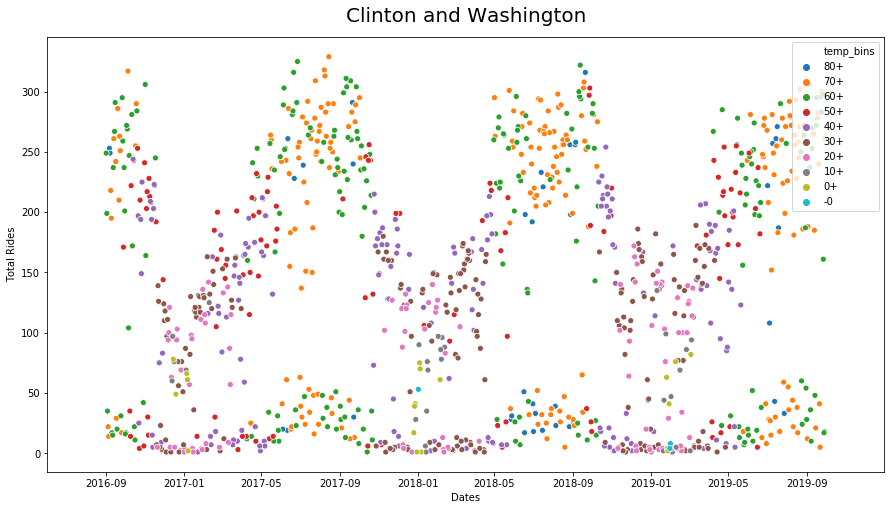

In [51]:
plt.figure(figsize=(15,8))
sns.scatterplot('date', 'total_rides', data=clinton_washington,hue='temp_bins')
plt.title('Clinton and Washington',fontdict={'fontsize':20},pad=15)
plt.legend(loc='upper right')
plt.xlabel('Dates')
plt.ylabel('Total Rides')
plt.xlim(left_bound, right_bound);


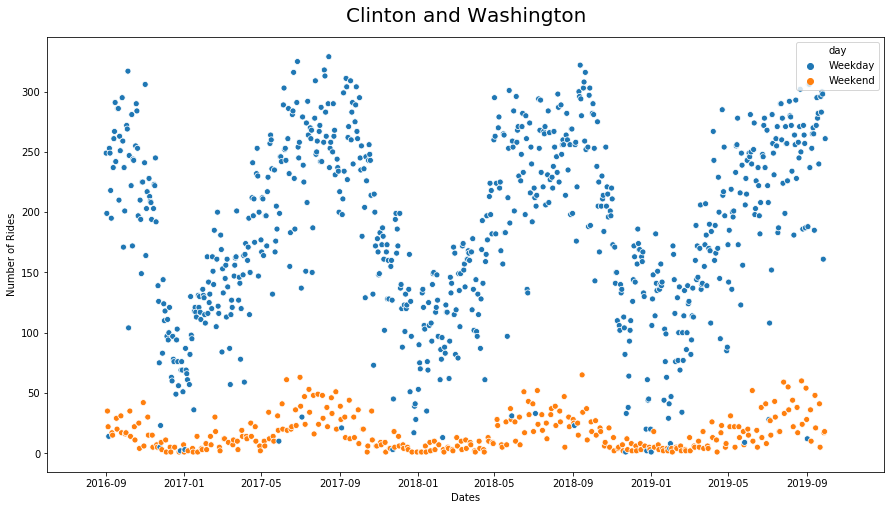

In [52]:
plt.figure(figsize=(15,8))
sns.scatterplot('date', 'total_rides', data=clinton_washington.sort_values('date'),hue='day')
plt.title('Clinton and Washington',fontdict={'fontsize':20},pad=15)
plt.legend(loc='upper right')
plt.xlabel('Dates')
plt.ylabel('Number of Rides')
plt.xlim(left_bound, right_bound);

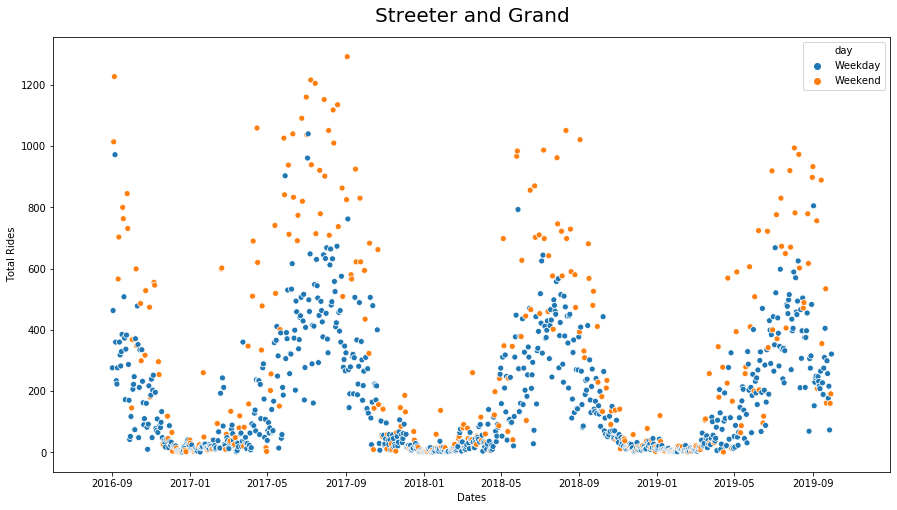

In [53]:
plt.figure(figsize=(15,8))
sns.scatterplot('date', 'total_rides', data=streeter_grand.sort_values('date'),hue='day')
plt.legend(loc='upper right')
plt.xlabel('Dates')
plt.ylabel('Total Rides')
plt.title('Streeter and Grand',fontdict={'fontsize':20},pad=15)
plt.xlim(left_bound, right_bound);

In [54]:
stations_to_drop = list(station_rides.query('trip_id < 3375')['from_station_name'])

In [55]:
over_2000 = ride_grouped_stations

print(f'number of stations before dropping stations: {over_2000.from_station_name.nunique()}')
over_2000 = over_2000[~over_2000['from_station_name'].isin(stations_to_drop)]
print(f'number of stations after dropping stations: {over_2000.from_station_name.nunique()}')

print(f'stations dropped: {696 - 488}')

number of stations before dropping stations: 696
number of stations after dropping stations: 441
stations dropped: 208


In [56]:
# create lists of top 20 stations
top_20 = ride_grouped_stations.groupby('from_station_name').agg({'total_rides':'sum'})
top_20 = top_20.reset_index().sort_values('total_rides').tail(20)
top_20 = list(top_20['from_station_name'])

In [57]:
# create a dataframe inclusive of the top 20 stations
top_20_df = ride_grouped_stations[ride_grouped_stations['from_station_name'].isin(top_20)].copy()

In [58]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [119]:
station_var = ols('total_rides~C(from_station_name) + day + temp', data=over_2000).fit()

In [120]:
sm.stats.anova_lm(station_var)

,df,sum_sq,mean_sq,F,PR(>F)
C(from_station_name),440.0,2.748348e+08,6.246246e+05,913.701145,0.0
day,1.0,1.536232e+06,1.536232e+06,2247.201129,0.0
temp,1.0,7.711722e+07,7.711722e+07,112807.114380,0.0
Residual,434773.0,2.972196e+08,6.836202e+02,NaN,NaN


In [121]:
station_var.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_rides   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     1170.
Date:                Fri, 24 Jan 2020   Prob (F-statistic):               0.00
Time:                        13:40:31   Log-Likelihood:            -2.0377e+06
No. Observations:              435216   AIC:                         4.076e+06
Df Residuals:                  434773   BIC:                         4.081e+06
Df Model:                         442                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================================
                                                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                             -18.7158      0.799    -23.437      0.000     -20.281     -17.151
C(from_station_name)[T.Aberdeen St & Jackson Blvd]                     14.2806      1.112     12.843      0.000      12.101      16.460
C(from_station_name)[T.Aberdeen St & Monroe St]                        10.7841      1.111      9.707      0.000       8.607      12.962
C(from_station_name)[T.Aberdeen St & Randolph St]                       9.2694      1.402      6.612      0.000       6.522      12.017
C(from_station_name)[T.Ada St & Washington Blvd]                        5.2610      1.113      4.725      0.000       3.079       7.443
C(from_station_name)[T.Adler Planetarium]                              37.3518      1.118     33.412      0.000      35.161      39.543
C(from_station_name)[T.Albany Ave & Bloomingdale Ave]                  -5.4970      1.118     -4.916      0.000      -7.689      -3.305
C(from_station_name)[T.Artesian Ave & Hubbard St]                      -1.3376      1.126     -1.188      0.235      -3.545       0.870
C(from_station_name)[T.Ashland Ave & 13th St]                         -11.5078      1.126    -10.217      0.000     -13.715      -9.300
C(from_station_name)[T.Ashland Ave & 21st St]                         -15.2201      1.155    -13.181      0.000     -17.483     -12.957
C(from_station_name)[T.Ashland Ave & Augusta Blvd]                     -1.5798      1.115     -1.417      0.156      -3.765       0.605
C(from_station_name)[T.Ashland Ave & Belle Plaine Ave]                -10.7752      1.157     -9.314      0.000     -13.043      -8.508
C(from_station_name)[T.Ashland Ave & Blackhawk St]                      1.0301      1.116      0.923      0.356      -1.158       3.218
C(from_station_name)[T.Ashland Ave & Chicago Ave]                       1.4909      1.113      1.339      0.181      -0.691       3.673
C(from_station_name)[T.Ashland Ave & Division St]                      30.7830      1.111     27.709      0.000      28.606      32.960
C(from_station_name)[T.Ashland Ave & Grace St]                         -4.1670      1.115     -3.738      0.000      -6.352      -1.982
C(from_station_name)[T.Ashland Ave & Grand Ave]                        -5.3182      1.118     -4.755      0.000      -7.510      -3.126
C(from_station_name)[T.Ashland Ave & Harrison St]                      -2.8823      1.202     -2.398      0.016      -5.238      -0.527
C(from_station_name)[T.Ashland Ave & Lake St]                          -4.7174      1.360     -3.468      0.001      -7.383      -2.052
C(from_station_name)[T.Ashland Ave & Lake St (Temp)]                   -1.9125      1.379  


| p.value       | Stations           | % Total  |
| :-------------: |:-------------:| :-----:|
| > 0.05      | 41 | 6% |
| < 0.05 | 654    |   94% |
| 0 | 613 | 88% |

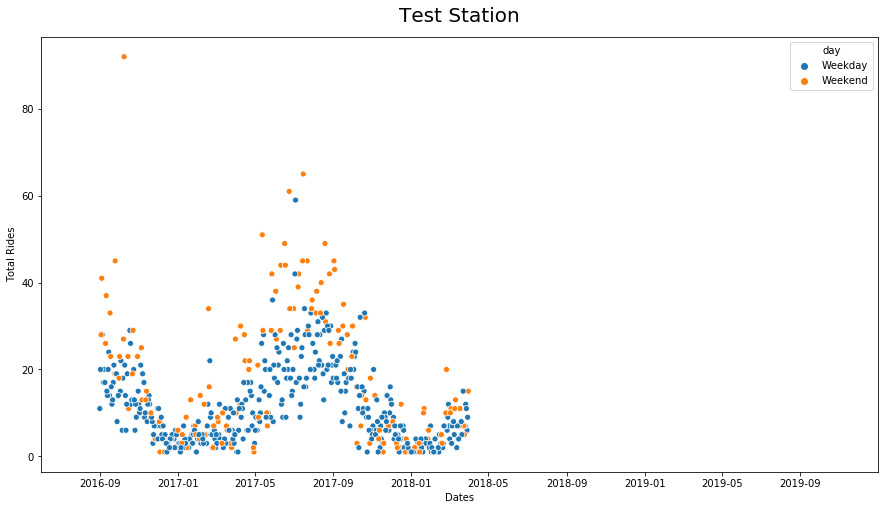

In [62]:
test_station = ride_grouped_stations.query('from_station_name == "Wentworth Ave & Archer Ave"')
test_station = test_station.sort_values('temp',ascending=False)

plt.figure(figsize=(15,8))
sns.scatterplot('date', 'total_rides', data=test_station,hue='day')
plt.title('Test Station',fontdict={'fontsize':20},pad=15)
plt.legend(loc='upper right')
plt.xlabel('Dates')
plt.ylabel('Total Rides')
plt.xlim(left_bound, right_bound);


In [63]:
import folium
from folium import plugins
from folium.plugins import HeatMap

chicago_coords = [41.908254, -87.694986]

In [64]:
ride_df['dow'] = ride_df['start_time'].dt.dayofweek
ride_df['dow'] = ride_df['dow'].map(lambda x: weekend(x))

In [77]:
counts = ride_df.groupby(['from_latitude','from_longitude']).count().reset_index()

In [86]:
lst = list(zip(counts['from_latitude'], counts['from_longitude'], counts['trip_id']))

In [91]:
coords = [[x[0],x[1],x[2]] for x in lst]

In [112]:
base_map = folium.Map(chicago_coords,
                      zoom_start=12, tiles='stamentoner')

# create heatmap
HeatMap(coords,radius=8, min_opacity=.1).add_to(base_map)

base_map